# 使用 Unsloth 对 DeepSeek-R1-Distill-Qwen-1.5B 模型进行 LoRA 微调

本 Notebook 展示了如何使用 `unsloth` 库对 `deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B` 模型进行高效的 QLoRA (Low-Rank Adaptation) 微调。

整个流程包括：
1.  环境准备与库导入
2.  加载预训练模型和分词器 (Tokenizer)。
3.  在微调前，对模型进行简单的推理测试。
4.  下载和格式化训练数据集
5.  使用 `unsloth` 的 `FastLanguageModel` 来为模型添加 LoRA 适配器。
6.  配置 `SFTTrainer` 监督微调训练配置。
7.  启动训练，并观察 Loss 变化情况
8.  保存微调后的模型
9.  测试训练后的生成结果

### 1. 环境准备与库导入

首先，我们需要安装并导入所有必要的库。`transformers` 用于加载模型和分词器，`unsloth` 用于高效微调，`trl` 提供了 `SFTTrainer`，而 `datasets` 用于处理数据。

**注意**: 在运行此 Notebook 之前，请确保已安装所有依赖包：
```bash
pip install -r requirements.txt
```

In [1]:
import torch
from unsloth import FastLanguageModel
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, GenerationConfig, DataCollatorForSeq2Seq
from datasets import Dataset

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


### 2. 加载预训练模型和分词器 (Tokenizer)

### 国内处理方法 下载文件
### 设置镜像源环境变量
export HF_ENDPOINT=https://hf-mirror.com
pip install huggingface-hub
huggingface-cli download unsloth/DeepSeek-R1-Distill-Qwen-1.5B

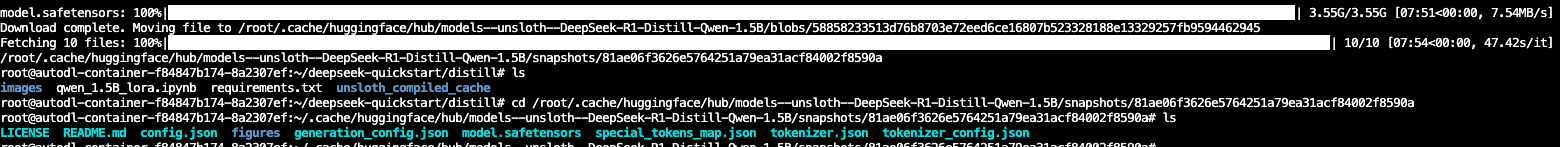

In [5]:
# 定义模型和一些基本参数
max_seq_length = 8192
dtype = None # None 表示自动选择 (Float16 a T4, V100, BFloat16 a Ampere)
load_in_4bit = True # 使用 4bit 量化加载

# 这是您的模型标识符，请替换为您正在使用的模型
# 例如："qwen-1.5b_lora_model"
# model_name = "qwen-1.5b_lora_model" 
model_name = "unsloth/DeepSeek-R1-Distill-Qwen-1.5B" 
#model_name = "unsloth/DeepSeek-R1-Distill-Qwen-1.5B-unsloth-bnb-4bit" 

# 这一步会返回一个经过 Unsloth 优化的模型和一个分词器
#model, tokenizer = FastLanguageModel.from_pretrained(
#    model_name = model_name,
#    max_seq_length = max_seq_length,
#    dtype = dtype,
#    load_in_4bit = load_in_4bit,
#)

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "/root/.cache/huggingface/hub/models--unsloth--DeepSeek-R1-Distill-Qwen-1.5B/snapshots/81ae06f3626e5764251a79ea31acf84002f8590a",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)


==((====))==  Unsloth 2025.8.5: Fast Qwen2 patching. Transformers: 4.55.2.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 1. Max memory: 23.527 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


### 3. 微调前推理测试

在对模型进行任何修改之前，我们先用它来生成一段文本，看看原始模型的表现如何。这可以作为我们微调效果的基准参考。

In [6]:
# 模型推理的 Prompt 模板
inference_prompt = """以下是一条描述任务的指令，并配有一个提供进一步上下文的输入。
请撰写一份恰当的回复，以完成该请求。
在回答之前，请仔细思考该问题，并构建一个分步的思考过程，以确保回应的逻辑严谨和内容准确。


### Instruction:
你是一位医学专家，在临床推理、诊断学和治疗规划方面拥有深厚的专业知识。
请回答以下医学问题。

### Question:
{}

### Response:
<think>{}
"""

In [7]:
FastLanguageModel.for_inference(model)

question = "男，28岁，程序员，最近一周每天工作到半夜，感觉头晕、脖子疼，有时候还恶心。"

inputs = tokenizer([inference_prompt.format(question, "")], return_tensors="pt").to("cuda")
attention_mask = inputs.input_ids.ne(tokenizer.pad_token_id).long().to("cuda")

outputs = model.generate(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    max_new_tokens=1200,
    use_cache=True,
)

In [8]:
response = tokenizer.batch_decode(outputs, skip_special_tokens=True)

In [9]:
print(response[0].split("### Response:")[1])


<think>
嗯，用户是一位28岁的男性，程序员，最近每天工作到半夜，感觉头晕、脖子疼，还有时候恶心。首先，我需要分析他的症状，可能与脑力劳动相关，也可能与压力、疲劳、熬夜等有关。

我应该先考虑是否存在脑力损伤，比如脑力运动损伤。通常，头晕、恶心可能与脑力活动有关，比如长时间的工作可能导致脑力损伤。另外，颈椎问题也可能引起颈部疼痛和恶心，需要考虑。

然后，我需要考虑是否存在睡眠问题，因为工作到半夜可能导致失眠。睡眠质量差可能影响对脑力活动的适应，进而影响症状。如果用户睡眠不好，可能会导致头晕和颈部疼痛。

另外，工作压力和疲劳也可能导致脑力损伤，需要考虑是否需要进一步的脑力损伤评估。如果症状持续，可能需要进行脑力损伤评估，以确定是否存在损伤。

还需要考虑是否需要药物治疗，比如抗抑郁药，以缓解症状。如果症状严重，可能需要药物支持。

此外，是否需要咨询神经科医生，特别是如果出现恶心、头晕，可能与恶心症有关，需要进一步检查。

总结来说，用户可能有脑力损伤，需要进行脑力损伤评估，同时考虑是否需要药物治疗。如果症状持续，可能需要进一步评估。建议用户咨询神经科医生，特别是恶心症的评估。
</think>

您最近的工作状态和症状可能与脑力损伤相关。以下是对您可能症状的评估和建议：

1. **症状分析**:
   - **头晕、脖子疼**：可能与脑力活动损伤有关。
   - **恶心**：可能与恶心症相关。

2. **可能的诊断**:
   - **脑力损伤评估**：评估是否有脑力损伤，如脑力运动损伤。
   - **压力评估**：评估工作压力和疲劳水平。
   - **睡眠评估**：评估睡眠质量，睡眠不好可能影响对脑力活动的适应。

3. **药物治疗**:
   - 如果有恶心，可能需要药物治疗，如抗抑郁药或胃 relaxants。

4. **建议**:
   - 禾顶咨询神经科医生，特别是恶心症的评估。
   - 如果症状持续，建议进行脑力损伤评估。
   - 如果有其他症状（如视力问题），可能需要进一步检查。

希望以上信息能帮助您进一步评估和治疗。如需要进一步的帮助，建议咨询专业医生。


---

### 4. 下载和格式化训练数据集


医学推理数据集：https://huggingface.co/datasets/FreedomIntelligence/medical-o1-reasoning-SFT/viewer/zh

![dataset](images/dataset.png)

### 本地安装 huggingface_hub
pip install huggingface_hub

### 下载数据集
huggingface-cli download FreedomIntelligence/medical-o1-reasoning-SFT --repo-type dataset --local-dir ./medical-o1-reasoning-SFT --local-dir-use-symlinks False

In [10]:
# 模型训练的 Prompt 模板
train_prompt = """以下是一条描述任务的指令，并配有一个提供进一步上下文的输入。
请撰写一份恰当的回复，以完成该请求。
在回答之前，请仔细思考该问题，并构建一个分步的思考过程，以确保回应的逻辑严谨和内容准确。


### Instruction:
你是一位医学专家，在临床推理、诊断学和治疗规划方面拥有深厚的专业知识。
请回答以下医学问题。

### Question:
{}

### Response:
<think>
{}
</think>
{}
"""

In [13]:
EOS_TOKEN = tokenizer.eos_token # 添加 EOS Token

def formatting_prompts_func(examples):
    inputs = examples["Question"]
    cots = examples["Complex_CoT"]
    outputs = examples["Response"]
    texts = []
    for input, cot, output in zip(inputs, cots, outputs):
        # 将 EOS Token 添加到样本最后
        text = train_prompt.format(input, cot, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("/root/medical-o1-reasoning-SFT", "zh", split = "train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/20171 [00:00<?, ? examples/s]

In [14]:
dataset[0]["text"]

'以下是一条描述任务的指令，并配有一个提供进一步上下文的输入。\n请撰写一份恰当的回复，以完成该请求。\n在回答之前，请仔细思考该问题，并构建一个分步的思考过程，以确保回应的逻辑严谨和内容准确。\n\n\n### Instruction:\n你是一位医学专家，在临床推理、诊断学和治疗规划方面拥有深厚的专业知识。\n请回答以下医学问题。\n\n### Question:\n根据描述，一个1岁的孩子在夏季头皮出现多处小结节，长期不愈合，且现在疮大如梅，溃破流脓，口不收敛，头皮下有空洞，患处皮肤增厚。这种病症在中医中诊断为什么病？\n\n### Response:\n<think>\n这个小孩子在夏天头皮上长了些小结节，一直都没好，后来变成了脓包，流了好多脓。想想夏天那么热，可能和湿热有关。才一岁的小孩，免疫力本来就不强，夏天的湿热没准就侵袭了身体。\n\n用中医的角度来看，出现小结节、再加上长期不愈合，这些症状让我想到了头疮。小孩子最容易得这些皮肤病，主要因为湿热在体表郁结。\n\n但再看看，头皮下还有空洞，这可能不止是简单的头疮。看起来病情挺严重的，也许是脓肿没治好。这样的情况中医中有时候叫做禿疮或者湿疮，也可能是另一种情况。\n\n等一下，头皮上的空洞和皮肤增厚更像是疾病已经深入到头皮下，这是不是说明有可能是流注或瘰疬？这些名字常描述头部或颈部的严重感染，特别是有化脓不愈合，又形成通道或空洞的情况。\n\n仔细想想，我怎么感觉这些症状更贴近瘰疬的表现？尤其考虑到孩子的年纪和夏天发生的季节性因素，湿热可能是主因，但可能也有火毒或者痰湿造成的滞留。\n\n回到基本的症状描述上看，这种长期不愈合又复杂的状况，如果结合中医更偏重的病名，是不是有可能是涉及更深层次的感染？\n\n再考虑一下，这应该不是单纯的瘰疬，得仔细分析头皮增厚并出现空洞这样的严重症状。中医里头，这样的表现可能更符合‘蚀疮’或‘头疽’。这些病名通常描述头部严重感染后的溃烂和组织坏死。\n\n看看季节和孩子的体质，夏天又湿又热，外邪很容易侵入头部，对孩子这么弱的免疫系统简直就是挑战。头疽这个病名听起来真是切合，因为它描述的感染严重，溃烂到出现空洞。\n\n不过，仔细琢磨后发现，还有个病名似乎更为合适，叫做‘蝼蛄疖’，这病在中医里专指像这种严重感染并伴有深部空洞的情况。它也涵盖了化脓和皮肤增厚这些症状。\n\n

In [15]:
from IPython.display import display, Markdown

display(Markdown(dataset[0]["text"]))

以下是一条描述任务的指令，并配有一个提供进一步上下文的输入。
请撰写一份恰当的回复，以完成该请求。
在回答之前，请仔细思考该问题，并构建一个分步的思考过程，以确保回应的逻辑严谨和内容准确。


### Instruction:
你是一位医学专家，在临床推理、诊断学和治疗规划方面拥有深厚的专业知识。
请回答以下医学问题。

### Question:
根据描述，一个1岁的孩子在夏季头皮出现多处小结节，长期不愈合，且现在疮大如梅，溃破流脓，口不收敛，头皮下有空洞，患处皮肤增厚。这种病症在中医中诊断为什么病？

### Response:
<think>
这个小孩子在夏天头皮上长了些小结节，一直都没好，后来变成了脓包，流了好多脓。想想夏天那么热，可能和湿热有关。才一岁的小孩，免疫力本来就不强，夏天的湿热没准就侵袭了身体。

用中医的角度来看，出现小结节、再加上长期不愈合，这些症状让我想到了头疮。小孩子最容易得这些皮肤病，主要因为湿热在体表郁结。

但再看看，头皮下还有空洞，这可能不止是简单的头疮。看起来病情挺严重的，也许是脓肿没治好。这样的情况中医中有时候叫做禿疮或者湿疮，也可能是另一种情况。

等一下，头皮上的空洞和皮肤增厚更像是疾病已经深入到头皮下，这是不是说明有可能是流注或瘰疬？这些名字常描述头部或颈部的严重感染，特别是有化脓不愈合，又形成通道或空洞的情况。

仔细想想，我怎么感觉这些症状更贴近瘰疬的表现？尤其考虑到孩子的年纪和夏天发生的季节性因素，湿热可能是主因，但可能也有火毒或者痰湿造成的滞留。

回到基本的症状描述上看，这种长期不愈合又复杂的状况，如果结合中医更偏重的病名，是不是有可能是涉及更深层次的感染？

再考虑一下，这应该不是单纯的瘰疬，得仔细分析头皮增厚并出现空洞这样的严重症状。中医里头，这样的表现可能更符合‘蚀疮’或‘头疽’。这些病名通常描述头部严重感染后的溃烂和组织坏死。

看看季节和孩子的体质，夏天又湿又热，外邪很容易侵入头部，对孩子这么弱的免疫系统简直就是挑战。头疽这个病名听起来真是切合，因为它描述的感染严重，溃烂到出现空洞。

不过，仔细琢磨后发现，还有个病名似乎更为合适，叫做‘蝼蛄疖’，这病在中医里专指像这种严重感染并伴有深部空洞的情况。它也涵盖了化脓和皮肤增厚这些症状。

哦，该不会是夏季湿热，导致湿毒入侵，孩子的体质不能御，其病情发展成这样的感染？综合分析后我觉得‘蝼蛄疖’这个病名真是相当符合。
</think>
从中医的角度来看，你所描述的症状符合“蝼蛄疖”的病症。这种病症通常发生在头皮，表现为多处结节，溃破流脓，形成空洞，患处皮肤增厚且长期不愈合。湿热较重的夏季更容易导致这种病症的发展，特别是在免疫力较弱的儿童身上。建议结合中医的清热解毒、祛湿消肿的治疗方法进行处理，并配合专业的医疗建议进行详细诊断和治疗。
<｜end▁of▁sentence｜>

### 5. 使用 Unsloth 添加 LoRA 适配器

这是使用 `unsloth` 的核心步骤。我们调用 `FastLanguageModel.get_peft_model`，它会非常高效地为模型注入 LoRA 模块。

- `r`: LoRA 的秩 (rank)，是控制模型复杂度和参数量的关键超参数。
- `target_modules`: 指定要在哪些线性层（如注意力机制的 q, k, v, o 投影层）上应用 LoRA。
- `lora_alpha`: LoRA 的缩放因子，通常设置为 `r` 的两倍或与 `r` 相同。
- `use_gradient_checkpointing`: 一种节省显存的技术，对于训练大模型至关重要。

In [16]:
# 因为 `model` 对象现在是由 Unsloth 创建的，它包含了所有必需的属性
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=[
      "q_proj",
      "k_proj",
      "v_proj",
      "o_proj",
      "gate_proj",
      "up_proj",
      "down_proj",
    ],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=1432,
    use_rslora=False,
    loftq_config=None,
)
# 检查模型结构，确认 LoRA 适配器已添加
print(model)

Unsloth 2025.8.5 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 1536, padding_idx=151654)
        (layers): ModuleList(
          (0-27): 28 x Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=1536, out_features=1536, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1536, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=1536, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora

### 6. 配置 SFTTrainer

`SFTTrainer` (Supervised Fine-tuning Trainer) 是一个专门用于指令微调的训练器。我们需要配置 `TrainingArguments` 来指定所有的训练参数，如批量大小、学习率、优化器等。

In [17]:
from trl import SFTConfig, SFTTrainer
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    packing = False, # Can make training 5x faster for short sequences.
    args = SFTConfig(
        per_device_train_batch_size = 64,
        gradient_accumulation_steps = 2,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 60,
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 1432,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/20171 [00:00<?, ? examples/s]

### 7. 开始训练

一切准备就绪后，调用 `trainer.train()` 即可开始微调过程。训练结束后，会返回包含训练统计信息（如训练损失）的对象。

In [18]:
trainer_stats = trainer.train()

# 打印训练统计信息
print(trainer_stats)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 20,171 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 64 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (64 x 2 x 1) = 128
 "-____-"     Trainable parameters = 18,464,768 of 1,795,552,768 (1.03% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,3.179800
2,3.186800
3,3.093400
4,3.183200
5,3.167100
6,3.024200
7,2.999900
8,2.961800
9,2.915200
10,2.811200


TrainOutput(global_step=60, training_loss=2.489056881268819, metrics={'train_runtime': 707.3082, 'train_samples_per_second': 10.858, 'train_steps_per_second': 0.085, 'total_flos': 7.163728311484416e+16, 'train_loss': 2.489056881268819})


### 8. 保存微调后的模型（Lora）

训练完成后，您可以再次进行推理，比较微调后的模型与原始模型的差异。如果对结果满意，可以使用 `model.save_pretrained("your_lora_adapter_path")` 来保存训练好的 LoRA 适配器。

In [19]:
model.save_pretrained("qwen-1.5b_lora_model")

In [20]:
tokenizer.save_pretrained("qwen-1.5b_lora_model")

('qwen-1.5b_lora_model/tokenizer_config.json',
 'qwen-1.5b_lora_model/special_tokens_map.json',
 'qwen-1.5b_lora_model/chat_template.jinja',
 'qwen-1.5b_lora_model/tokenizer.json')

In [21]:
# 模型保存方式二选一（要么使用上面的分开保存，要么使用这里的合并 Lora 保存）
# model.save_pretrained_merged("qwen-1.5b_lora_model", tokenizer, save_method="merged_16bit")

### 9. 测试训练后的生成结果

In [28]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

question="一个患有急性阑尾炎的病人已经发病5天，腹痛稍有减轻但仍然发热，在体检时发现右下腹有压痛的包块，此时应如何处理？", # Question
inputs = tokenizer([inference_prompt.format(question, "")], return_tensors="pt").to("cuda")

outputs = model.generate(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    max_new_tokens=1000,
    use_cache=True,
)

In [30]:
output = tokenizer.batch_decode(outputs, skip_special_tokens=True)
print(output[0].split("### Response:")[1])


<think>
这个病人已经5天了，急性阑尾炎，疼痛和发热，还有压痛包块。首先，我得想想，急性阑尾炎通常是因为阑尾炎性囊肿压迫导致的疼痛和发热。所以，压痛包块可能与阑尾炎有关，可能需要进一步检查。

接下来，我想看看是否有其他因素可能影响，比如肝功能问题，因为病人有发热，这可能影响肝功能。所以，肝功能检查是个必要步骤。

然后，我想到了做CT扫描，这样可以更清楚地看到压痛包块的位置和大小。CT扫描能帮助我们更好地理解包块，从而制定更好的治疗方案。

我还想到，如果包块比较大或者有压迫性，可能需要进行手术，但也要考虑手术的风险和效果。所以，手术前的评估和讨论也是很重要的。

此外，建议病人保持规律的饮食，减少酒精摄入，因为酒精可能会加重疼痛。同时，避免剧烈运动，以防止影响恢复。

最后，我想到了检查肝功能，因为患者有发热，可能影响肝功能。如果肝功能有问题，建议进行肝功能检查，以评估是否有肝损伤。

总之，这个病人需要做CT扫描，评估包块的位置和大小，然后根据需要决定是否手术。同时，还要注意饮食和避免某些活动，以促进恢复。
</think>
根据患者描述，病人患有急性阑尾炎，已经5天，腹痛轻微减轻但仍有发热，且在体检时发现右下腹有压痛包块。根据临床推理，这种情况通常与阑尾炎性囊肿压迫导致的疼痛和发热有关。因此，压痛包块的处理需要谨慎考虑。

首先，建议进行肝功能检查，因为患者有发热，可能影响肝功能。肝功能检查有助于评估是否有肝损伤，从而指导治疗策略。

其次，CT扫描是必要的，以更好地评估压痛包块的位置和大小，以便制定有效的治疗方案。CT扫描能够提供更详细的信息，有助于确定包块的压迫程度和分布。

此外，患者应避免剧烈运动，以免影响恢复。同时，饮食方面，应尽量减少酒精摄入，以避免加重疼痛。此外，建议定期复查肝功能，以评估肝损伤的严重程度。

在处理压痛包块时，如果包块较大或压迫性强，建议进行手术，但手术的风险和效果需要根据具体情况综合评估。因此，患者在进行治疗时，应根据临床判断和治疗效果，结合手术风险进行综合规划。



In [31]:
def generate_response(question: str, model, tokenizer, inference_prompt: str, max_new_tokens: int = 1024) -> str:
    """
    使用指定的模型和分词器为给定的医学问题生成响应。

    Args:
        question (str): 需要模型回答的医学问题。
        model: 已加载的 Unsloth/Hugging Face 模型。
        tokenizer: 对应的分词器。
        inference_prompt (str): 用于格式化输入的 f-string 模板。
        max_new_tokens (int, optional): 生成响应的最大 token 数量。默认为 1024。

    Returns:
        str: 模型生成的响应文本，已去除 prompt 部分。
    """
    # 1. 使用模板格式化输入
    prompt = inference_prompt.format(
        question, # 填充问题
        "",       # 留空，让模型生成 CoT 和 Response
    )

    # 2. 将格式化后的 prompt 进行分词，并转移到 GPU
    inputs = tokenizer([prompt], return_tensors="pt").to(model.device)

    # 3. 使用模型生成输出
    # use_cache=True 用于加速解码过程
    outputs = model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=max_new_tokens,
        use_cache=True,
    )
    
    # 4. 将生成的 token 解码为文本
    # skip_special_tokens=True 会移除像 EOS_TOKEN 这样的特殊标记
    decoded_output = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

    # 5. 切分字符串，只返回 "### Response:" 之后的部分
    # 使用 .split() 分割并获取响应内容，.strip() 用于去除可能存在的前后空白字符
    response_part = decoded_output.split("### Response:")
    if len(response_part) > 1:
        return response_part[1].strip()
    else:
        # 如果模型没有生成 "### Response:" 标记，则返回整个生成内容以供调试
        return decoded_output

In [32]:
my_question = "对于一名60岁男性患者，出现右侧胸疼并在X线检查中显示右侧肋膈角消失，诊断为肺结核伴右侧胸腔积液，请问哪一项实验室检查对了解胸水的性质更有帮助？"

response = generate_response(my_question, model, tokenizer, inference_prompt)
print("==================== 模型回答 ====================")
print(response)

==================== 模型回答 ====================
<think>
嗯，这位60岁男性患者，出现右侧胸疼，X线检查显示右肋膈角消失，这让我想到肺结核。肺结核通常会导致胸腔积液，对吧？那这个积液的性质到底是什么呢？

首先，我得想想，肺结核患者的胸腔积液是怎样的呢？是液体还是固体？我记得，肺结核可能与肺泡结核有关，导致了肺部的液体积液。而胸腔积液，应该是液体的，对吗？

那这样，当X线检查显示右肋膈角消失时，我们可能需要进一步的检查，看看这种液体的性质。因为如果肺结核导致的液体积液，通常会是液体，所以可能需要一些液体分析来确认。

现在，我回想一下，实验室中常用的液体分析方法有哪些。常用的液体分析有血常规、白细胞计数、血球分析等等。不过，这些方法主要是用来分析白细胞和血细胞的数目，不能直接检测液体的性质。

哦，对了，血沉实验是用来检测液体的。如果进行血沉实验，如果血沉时间过长，可能表明液体的量很大，这可能就是肺结核患者的情况，因为肺结核通常会导致较多的液体积液。所以，血沉实验能帮助我们判断这个液体是液体还是固体。

嗯，再想想，还有其他液体分析方法吗？比如血浆蛋白，或者血浆中的蛋白质，不过这些主要是检测血浆中蛋白质的，不能直接检测液体的性质。而血沉实验，尤其是血沉时间的长短，可以作为判断液体的特征的依据。

所以，看来血沉实验是更合适的选择。它能帮助我们判断液体积液的性质，从而帮助我们更好地诊断肺结核的伴随胸腔积液。

嗯，这样看来，血沉实验是很有帮助的。它能通过血沉时间的变化来判断液体的量，从而帮助我们了解这个液体的性质，所以，在这种情况下，血沉实验应该是用来判断肺结核患者伴随胸腔积液性质的最合适的方法。

嗯，嗯，这样看来，我应该得出结论，血沉实验能帮助我们了解肺结核患者伴随胸腔积液的性质。
</think>
对于肺结核患者伴随右侧胸腔积液的情况，血沉实验是判断液体性质的最有效方法。血沉实验通过测量血浆在血管中的流动时间来判断液体的总量。在肺结核患者中，由于肺部的液体积液较多，血沉时间通常会较长。因此，通过血沉实验可以判断肺结核患者伴随的胸腔积液的性质，从而帮助我们更好地诊断和治疗。


In [33]:
my_question = "对于一名 28 岁的男性患者，工作是程序员，常年熬夜，最近突然感觉头晕目眩，甚至有点恶心。请问有可能是什么疾病？"

response = generate_response(my_question, model, tokenizer, inference_prompt)
print("==================== 模型回答 ====================")
print(response)

==================== 模型回答 ====================
<think>
嗯，这位28岁的男性患者，工作是程序员，经常熬夜，最近突然感觉头晕目眩，甚至有点恶心。这让我想到可能是什么疾病呢？首先，头晕目眩和恶心这感觉很常见，尤其是晚上，可能与某些脑部疾病有关。

嗯，想到了高血压，特别是中风后可能有高血压病。高血压是常见的慢性疾病，尤其是与心脑血管疾病有关的。这种患者可能因为工作压力大，熬夜导致血压升高，进而引发高血压。

不过，高血压患者通常会有头晕目眩的困扰，尤其是夜间。而这位患者的情况看起来更符合高血压这一类别。此外，高血压患者在夜间通常会有头晕、恶心等症状，和这个患者的症状相符。

嗯，再想想，是不是还有其他可能性呢？比如心脑血管疾病，比如心脑血管炎，这种疾病通常会有头晕目眩，甚至恶心，而心脑血管炎的患者通常需要及时处理，因为一旦出现剧烈的头晕，可能会有严重的危险。

哦，对了，心脏的问题也是一个可能，特别是心脑血管疾病。这种疾病通常在夜间表现得更明显，因为心脏功能异常可能更影响心脑血管的正常功能。

嗯，不过，高血压和心脑血管炎这两种疾病都是可能的，但高血压可能更直接关联到患者的症状。因为高血压患者通常有更严重的症状，尤其是在夜间，而心脑血管炎患者在夜间也容易出现这些症状。

嗯，那么，我再想想，高血压患者在夜间有头晕目眩，甚至有点恶心，这确实是一个典型的高血压症状，尤其是高血压病后。

嗯，可能的，不过，我得再确认一下，有没有其他可能的疾病也会有类似的情况。比如，糖尿病、心血管疾病，这些可能也会有头晕、恶心，但高血压和心脑血管疾病可能更直接。

嗯，嗯，嗯，好吧，综合考虑，高血压可能就是这个患者最可能的疾病，因为高血压的高血压通常会导致这些症状。
</think>
这位28岁的男性患者，工作是程序员，经常熬夜，最近突然感觉头晕目眩，甚至有点恶心。这种症状和高血压、心脑血管疾病等常见疾病有相似之处。高血压患者通常会有头晕目眩的困扰，尤其是夜间。心脑血管疾病患者在夜间也容易出现这些症状。

高血压是一种常见慢性疾病，尤其在心脑血管疾病患者中，高血压患者通常会有更严重的症状，尤其是在夜间。因此，高血压可能就是这个患者最可能的疾病。

当然，糖尿病和心血管疾病也是有可能的，但高血压和心脑血管疾病更直接关联到患者的症状。因此，高血